In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

%load_ext autoreload
%autoreload 1
%aimport regressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 0: Pre-processing

### Loading the data

Our CSV file is unlabeled, so we create our column names following the description in spambase.DOCUMENTATION:

In [146]:
word_freq_names = [f'word_freq_{i}' for i in range(1, 49)]
char_freq_names = [f'char_freq_{i}' for i in range(1, 7)]
cap_run_features = ['capital_run_length_' + s for s in ['average', 'longest', 'total']]

col_names = (
    word_freq_names +
    char_freq_names +
    cap_run_features +
    ['spam']
)

In [147]:
df = pd.read_csv('../data/spambase.data', header=None, names=col_names)
df.head()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Feature normalization

We can see that the ranges of the values for our integral features are quite large relative to our word and char frequencies:

In [148]:
df[cap_run_features].describe()

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000
mean,5.191515,52.172789,283.289285
std,31.729449,194.891310,606.347851
min,1.000000,1.000000,1.000000
25%,1.588000,6.000000,35.000000
50%,2.276000,15.000000,95.000000
75%,3.706000,43.000000,266.000000
max,1102.500000,9989.000000,15841.000000


I tried to train the regressor without normalizing at first, but the sigmoid function saturated, and we were getting numerical issues of taking logs of 0 in our cross entropy loss as a consequence. To address this, we use min-max normalization to make our integral count features in line with our 0-1 word and char frequency features.

In [149]:
cap_minima = df[cap_run_features].min()
cap_maxima = df[cap_run_features].max()

df[cap_run_features] =  ( (df[cap_run_features] - cap_minima) /
                         (cap_maxima - cap_minima) )

In [150]:
df[cap_run_features].describe()

,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000
mean,0.003805,0.005123,0.017821
std,0.028806,0.019513,0.038280
min,0.000000,0.000000,0.000000
25%,0.000534,0.000501,0.002146
50%,0.001158,0.001402,0.005934
75%,0.002457,0.004205,0.016730
max,1.000000,1.000000,1.000000


### Random Seed

For reproducibility, we'll set the seed for the random generators we use (e.g. for train-test spliiting, stochastic gradient descent, etc...).

In [151]:
rng_seed = 551
rng = np.random.default_rng(seed=rng_seed)

### Train-test split

We'll implement a train-test split of 5-95, that is, we use 5% of the data for training, and hold out the remaining 95% for testing. (In the interest of implementing our classifier from 'scratch', we don't use train_test_split from scikit-learn.)

In [152]:
train_ratio = 0.05
N = len(df)

# Train-test split
df_perm = df.iloc[rng.permutation(N)]
split_index = int(N * train_ratio)
df_train = df_perm.iloc[:split_index]
df_test = df_perm.iloc[split_index:]

X_train = df_train.drop(columns=['spam'])
y_train = df_train['spam']
X_test = df_test.drop(columns=['spam'])
y_test = df_test['spam']

## Task 1: Logistic Regression with SGD

In [153]:
from regressor import LogisticRegressor

We'll initialize two logistic regressors, one with no regularization and the other with regularization strength 0.001, to compare their loss curves. We'll initialize the remaining hyperparameters to the following values:
- batch_size = 1
- learning_rate = 0.01
- num_epochs = 100

In [154]:
reg_str = 0.001

In [155]:
import warnings
warnings.filterwarnings("error")

In [156]:
model_no_reg = LogisticRegressor(seed=551)
model_reg = LogisticRegressor(regularization_strength=reg_str, seed=551)

learning_curve_no_reg = model_no_reg.fit(X_train.to_numpy(), y_train.to_numpy(), 
                                         learning_curve=True)
learning_curve_reg = model_reg.fit(X_train.to_numpy(), y_train.to_numpy(), 
                                   learning_curve=True)                 

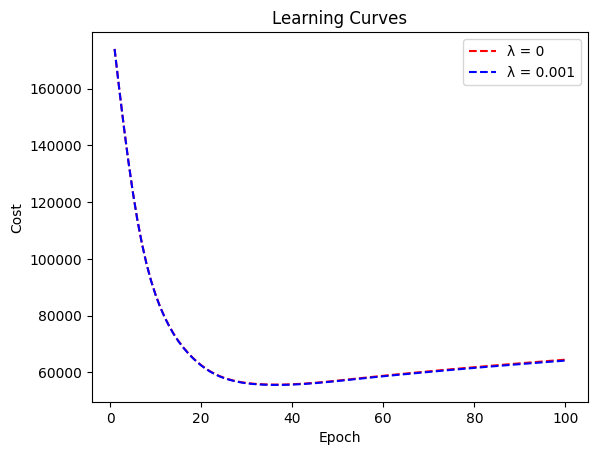

In [157]:
plt.plot(np.arange(1, model_no_reg.num_epochs + 1), 
            learning_curve_no_reg, 
            'r--', label='\u03BB = 0')
plt.plot(np.arange(1, model_reg.num_epochs + 1),
            learning_curve_reg,
            'b--', label=f'\u03BB = {reg_str}')

plt.xlabel("Epoch") 
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()